# dev measure birth/death events recursively

In [3]:
from lib.my_initialization import *
from lib.controller.controller_LR import get_one_step_explicit_synchronous_splitting
from lib.model.LR_model import *
from lib.utils.utils_traj import *
from lib.routines.bdrates import *
from lib.measure.utils_measure_tips_cpu import *
from lib.utils.stack_txt_LR import *
from lib.viewer import *
import trackpy
from lib.utils import load_buffer
from lib.routines.return_min_distance import *

#automate the boring stuff
# from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
    
%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


# identify two time ordered death events

In [11]:
x_lst=[100,23,43];y_lst=['c','b','cc'];s1_lst=['c','b','cc'];s2_lst=['c','b','cc']
_values=np.array(list(zip(x_lst,y_lst,s1_lst,s2_lst)))

in_to_sorted_values=np.argsort(x_lst)
x_lst=tuple(np.array(x_lst)[in_to_sorted_values])
y_lst=tuple(np.array(y_lst)[in_to_sorted_values])
s1_lst=tuple(np.array(s1_lst)[in_to_sorted_values])
s2_lst=tuple(np.array(s2_lst)[in_to_sorted_values])
# x_lst,y_lst,s1_lst,s2_lst=_values[in_to_sorted_values]

[['100' 'c' 'c' 'c']
 ['23' 'b' 'b' 'b']
 ['43' 'cc' 'cc' 'cc']]
[1 2 0]


array([ 23,  43, 100])

In [2]:
txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_218.8.npz'
t=218.8
dt=0.01
txt=load_buffer(txt_fn)
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
width,height=txt.shape[:2]
print(f"txt.shape={txt.shape}")

V_threshold=-50
jump_threshold = 40
ds=5.0
# get_one_step
__, arr39, one_step = get_one_step_explicit_synchronous_splitting(
    nb_dir,dt,width,height,ds,diffCoef=0.0005,Cm=1.0)

#the heavyweight spiral tip measures
comp_dict_tips=get_comp_dict_topo_full_color(width=width,height=height,level1=V_threshold,level2=0,
                                             jump_threshold=jump_threshold,ds=ds)
# comp_dict_tips=get_compute_all_spiral_tips(width, height, mode='simp')
comp_distance=get_distance_L2_pbc(width,height)
#measure tips that are already present topologically (slower)
img=inVc[...,0];dimgdt=dVcdt[...,0]
# dict_topo=comp_dict_topo_simple(img,dimgdt,t)
dict_topo=comp_dict_tips(img,dimgdt,t,txt)
pid_lst_all=dict_topo['pid']
n_tips=len(pid_lst_all)
print(f'ntips={n_tips}')
#initialize system
pdict=ParticlePBCDict(dict_tips=dict_topo, width=width, height=width)#, **kwargs)
t_prev=t;txt_prev=txt.copy()
# #zoom system (increases runtime and precision at long timescales)
# txt,pdict=zoom_system(txt,pdict)
# txt,pdict=zoom_system(txt,pdict)
# dt=dt/10
# width,height=txt.shape[:2]
# comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height,level1=V_threshold,level2=0)
x_values,y_values,pid_values=pdict.get_current_locations()
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
img=inVc[...,0];dimgdt=dVcdt[...,0]

scale=ds/width
xy_values=np.array(tuple(zip(x_values,y_values)))
assert(xy_values[0].shape[0]==2)

#compute minimum distance of all pid found
item_lst=[]
for i in range(n_tips):
    for j in range(n_tips):
        if i > j:
            #the ith tip location
            point1=xy_values[i]
            #the jth tip location
            point2=xy_values[j]
            #their distance, in cm
            dist=comp_distance(point1,point2)
            #add to list of distances
            item=(dist,i,j)
            item_lst.append(item)
item_lst=sorted(item_lst)
item_lst

#identify the pairs to follow to existential event
num_pairs_to_follow=2
pid_pair_lst=[]
for item in item_lst[:num_pairs_to_follow]:
    d,i,j=item
    pid_pair=i,j
    pid_pair_lst.append(pid_pair)


#define initialization target points as
point_target_init_lst=[]
for pid_pair in pid_pair_lst:
    #the  mean location of these tips 
    point_target_init=np.mean((x_values[pid_pair[0]],x_values[pid_pair[1]])),np.mean((y_values[pid_pair[0]],y_values[pid_pair[1]]))
    point_target_init_lst.append(point_target_init)

#set range to some value
#the ith tip location
point1=np.array(point_target_init_lst[0])
#the jth tip location
point2=np.array(point_target_init_lst[1])
#their distance, in cm
r=comp_distance(point1,point2)*scale #cm distance between the targets
print(f'there are {r:.3f} cm distance between the first and second targets.')

(200, 200, 18)
ntips=4


In [ ]:
#initialize system
pdict=ParticlePBCDict(dict_tips=dict_topo, width=width, height=width)#, **kwargs)
t_prev=t;txt_prev=txt.copy()
# #zoom system
# txt,pdict=zoom_system(txt,pdict)
# txt,pdict=zoom_system(txt,pdict)
# dt=dt/10
# width,height=txt.shape[:2]
# comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height,level1=V_threshold,level2=0)
x_values,y_values,pid_values=pdict.get_current_locations()
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
img=inVc[...,0];dimgdt=dVcdt[...,0]

scale=ds/width
xy_values=np.array(tuple(zip(x_values,y_values)))
assert(xy_values[0].shape[0]==2)

In [ ]:
#compute minimum distance of all pid found
item_lst=[]
for i in range(n_tips):
    for j in range(n_tips):
        if i > j:
            #the ith tip location
            point1=xy_values[i]
            #the jth tip location
            point2=xy_values[j]
            #their distance, in cm
            dist=comp_distance(point1,point2)
            #add to list of distances
            item=(dist,i,j)
            item_lst.append(item)
item_lst=sorted(item_lst)
item_lst

In [ ]:
#identify the pairs to follow to existential event
num_pairs_to_follow=2
pid_pair_lst=[]
for item in item_lst[:num_pairs_to_follow]:
    d,i,j=item
    pid_pair=i,j
    pid_pair_lst.append(pid_pair)


In [ ]:
#define initialization target points as
point_target_init_lst=[]
for pid_pair in pid_pair_lst:
    #the  mean location of these tips 
    point_target_init=np.mean((x_values[pid_pair[0]],x_values[pid_pair[1]])),np.mean((y_values[pid_pair[0]],y_values[pid_pair[1]]))
    point_target_init_lst.append(point_target_init)

In [ ]:
#set range to some value
#the ith tip location
point1=np.array(point_target_init_lst[0])
#the jth tip location
point2=np.array(point_target_init_lst[1])
#their distance, in cm
r=comp_distance(point1,point2)*scale #cm distance between the targets
print(f'there are {r:.3f} cm distance between the first and second targets.')

In [54]:
# from inspect import getsource
# print(getsource(find_stopping_point))

# estimate time ordering the death events (~7 min runtime...)

In [110]:
#find txt_prev, and approximate time of death for each tip
t_death_lst=[]
for pid_pair in pid_pair_lst:
    #TODO: def follows_pair_to_death(txt,pdict,pid_pair,atol,dt,ds):
    #slow high precision method
    # txt_prev,t_prev,min_sigma_max=find_stopping_point(dt, pdict, txt_prev, t_prev, save_every_n_frames=1)
    
    #find txt_prev near the death of the first tip pair fast low precision method
    #TODO(if output looks funny): run more tests on find_stopping_point
    txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=1000,V_threshold=V_threshold,pid_pair=pid_pair)
    t_death_lst.append(t_prev+dt*1000)
    
    #init txt for the next tip
    txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_218.8.npz'
    t=218.8;dt=0.01
    txt=load_buffer(txt_fn);width,height=txt.shape[:2]
    inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
    #measure tips that are already present topologically (slower)
    img=inVc[...,0];dimgdt=dVcdt[...,0]
    # dict_topo=comp_dict_topo_simple(img,dimgdt,t)
    dict_topo=comp_dict_tips(img,dimgdt,t,txt)
    pid_lst_all=dict_topo['pid']
    n_tips=len(pid_lst_all)
    boo=n_tips>0
    
    # #zoom system
    # txt,pdict=zoom_system(txt,pdict)
    # txt,pdict=zoom_system(txt,pdict)
    # width,height=txt.shape[:2]
    # comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height,level1=V_threshold,level2=0)
    # x_values,y_values,pid_values=pdict.get_current_locations()
    pdict=ParticlePBCDict(dict_tips=dict_topo, width=width, height=width)#, **kwargs)
    t_prev=t;txt_prev=txt.copy()

death event found for pid_pair=(3, 2) at time t=228.79999999999092, where dt=0.01 and L=200...
	 min_sigma_max=0.01397989604501346 cm
death event found for pid_pair=(1, 0) at time t=248.79999999997273, where dt=0.01 and L=200...
	 min_sigma_max=0.014290084392902717 cm


# recursively zoom into list of death events

In [8]:
#output from ^that takes 7 minutes...
sorted_indices_pid_pair_lst=[0,1]
t_death_lst=[218.81, 238.8099999999818]
print(f"t={t:0.2f}")
#DONE: enforce sorting of tips at a low level that integrates with all pythonic methods

t=218.80


In [9]:
#determine which pid_pair dies first
# item=t_death,pid_pair
sorted_indices_pid_pair_lst=np.argsort(t_death_lst)
# boo is whether the last pid_pair died last)
boo=t_death_lst[-1]==np.min(np.array(t_death_lst))
# #or just reinitialize and brute force through everything
# boo=True
#return sorted_indices_pid_pair_lst, t_death_lst, pid_pair_list

In [99]:
V_threshold=-50
jump_threshold = 40
ds=5.0
# get_one_step
__, arr39, one_step = get_one_step_explicit_synchronous_splitting(
    nb_dir,dt,width,height,ds,diffCoef=0.0005,Cm=1.0)

#the heavyweight spiral tip measures
comp_dict_tips=get_comp_dict_topo_full_color(width=width,height=height,level1=V_threshold,level2=0,
                                             jump_threshold=jump_threshold,ds=ds)
# comp_dict_tips=get_compute_all_spiral_tips(width, height, mode='simp')
comp_distance=get_distance_L2_pbc(width,height)

In [100]:
#measure tips that are already present topologically (slower)
img=inVc[...,0];dimgdt=dVcdt[...,0]
# dict_topo=comp_dict_topo_simple(img,dimgdt,t)
dict_topo=comp_dict_tips(img,dimgdt,t,txt)
pid_lst_all=dict_topo['pid']
n_tips=len(pid_lst_all)
n_tips

4

dict_keys(['x', 'y', 's1', 's2', 't', 'pid', 'greater_pid', 'lesser_pid', 'greater_arclen', 'lesser_arclen', 'greater_arclen_values', 'lesser_arclen_values', 'greater_mean_V', 'lesser_mean_V', 'greater_mean_curvature', 'lesser_mean_curvature', 'greater_xy_values', 'lesser_xy_values', 'greater_V_values', 'lesser_V_values', 'greater_curvature_values', 'lesser_curvature_values'])

In [16]:
#or just reinitialize and brute force through everything once in order
boo=False
# if the final pid_pair in pid_pair_lst didn't die first, reinititialize txt and pdict
if not boo:
    txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_218.8.npz'
    t=218.8
    dt=0.01
    txt=load_buffer(txt_fn)
    inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
    width,height=txt.shape[:2]
    print(txt.shape)
    one_step,comp_distance,comp_dict_tips=init_methods(width,height,ds,dt,V_threshold=-50,jump_threshold=40)
    comp_dict_topo_full_color=comp_dict_tips
    #reidentify the tips to be tracked
    dict_tips=comp_dict_tips(img, dimgdt, t, txt)
    pdict=ParticlePBCDict(dict_tips=dict_tips, width=width, height=width)#, **kwargs)
    t_prev=t;txt_prev=txt.copy()


(200, 200, 18)


In [48]:
scale=ds/width
xy_values=np.array(tuple(zip(x_values,y_values)))
assert(xy_values[0].shape[0]==2)

In [17]:
# zooming in as needed, until a certain absolute tolerance is found in a zero minimum distance between tips is reached.  
# consider
dict_atol={'test':1e-2,'batch':1e-4,'precise':1e-6}
atol=dict_atol['test']
tfactor=0.1

In [18]:
#for each pid_pair
for q in sorted_indices_pid_pair_lst:
    pid_pair=pid_pair_lst[q]
    boo=check_atol(pdict,pid_pair,atol,index=-1,ds=ds)
    #while atol is not reached:
    while not boo:
        kwargs={'one_step':one_step,
               'comp_dict_topo_full_color':comp_dict_topo_full_color,
               'V_threshold':V_threshold,
               'pid_pair':pid_pair}
        #find stopping point, integrating up to the death of the first particle
        txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=100,**kwargs)
#                                                           V_threshold=V_threshold,pid_pair=pid_pair)
        txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=10,**kwargs)
#                                                           V_threshold=V_threshold,pid_pair=pid_pair)
        txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=1,**kwargs)
#                                                           V_threshold=V_threshold,pid_pair=pid_pair)
        t_death_lst[q]=t_prev+dt
        boo=check_atol(pdict,pid_pair,atol,index=-1,ds=ds)
        if not boo:
            #reset to txt_prev. zoom system.
            dt=tfactor*dt
            txt_prev,pdict=zoom_system(txt_prev,pdict)
            width,height=txt_prev.shape[:2]
            print(f'zoomed to dsdpixel={ds/width} cm/pxl for pid_pair, {pid_pair}...')
            #jit compile the one_step_kernel and measure_subkernel
            one_step,comp_distance,comp_dict_topo_full_color=init_methods(width,height,ds,dt,jump_threshold=40,**kwargs)
#             __, __, one_step = get_one_step_explicit_synchronous_splitting(nb_dir,
#                                                                            dt=dt,width=width,height=height,
#                                                                            ds=ds,diffCoef=0.0005,Cm=1.0)
#             comp_dict_topo_full_color=get_comp_dict_topo_full_color(width=width,height=height,level1=V_threshold,level2=0)
            
beep(10)
print(pdict)
#TODO: test ^this
#TODO: plot ^this... does it look reasonable?
#TODO: put ^this in a function/routine in return_min_distance.py 
#TODO: make a return_min_distance.sh file that runs ^this python function to a high precision, prints to a text file, and saves some out.csv

death event found for pid_pair=(1, 0) at time t=220.7999999999982, where dt=0.01 and L=200...
	 min_sigma_max=0.013536455211009588 cm
death event found for pid_pair=(1, 0) at time t=219.899999999999, where dt=0.01 and L=200...
	 min_sigma_max=0.013536455211009588 cm
death event found for pid_pair=(1, 0) at time t=219.86999999999904, where dt=0.01 and L=200...
	 min_sigma_max=0.013535214153667072 cm
zoomed to dsdpixel=0.0125 cm/pxl for pid_pair, (1, 0)...
death event found for pid_pair=(1, 0) at time t=219.95999999999952, where dt=0.001 and L=400...
	 min_sigma_max=0.013535214153667072 cm
death event found for pid_pair=(1, 0) at time t=219.87999999999914, where dt=0.001 and L=400...
	 min_sigma_max=5.117222985861741e-07 cm
death event found for pid_pair=(1, 0) at time t=219.8709999999991, where dt=0.001 and L=400...
	 min_sigma_max=5.117222985861741e-07 cm
zoomed to dsdpixel=0.00625 cm/pxl for pid_pair, (1, 0)...
death event found for pid_pair=(1, 0) at time t=219.88999999999976, where 

# TODO: save and visualize the results and then analyze them in a serparate notebook

In [43]:
# import json
# import numpy as np

# class NpEncoder(json.JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, np.integer):
#             return int(obj)
#         elif isinstance(obj, np.floating):
#             return float(obj)
#         elif isinstance(obj, np.ndarray):
#             return obj.tolist()
#         else:
#             return super(NpEncoder, self).default(obj)

In [57]:
# def save_dict_to_json(dict_in,save_fn):
#     #save all output values as json
#     os.system('touch '+save_fn)
#     with open(save_fn,"w") as fp:
#         json.dump(dict(dict_in),fp,cls=NpEncoder,indent=1,sort_keys=True)

In [91]:
#save all output values as json
save_fn=f"{nb_dir}/Data/test_data/recursive_death_test_full.json"
save_dict_to_json(pdict,save_fn)

0

In [101]:
# def separate_data_to_dicts(particle):
#     '''separates contour data from particle data for one particle.
#     does not change particle.
#     Example Usage:
#     dict_particle_out,dict_greater,dict_lesser=separate_data_to_dicts(particle)
#     '''
#     pid=particle.pid
#     dict_particle=dict(particle)
#     #remove any numpy array objects _values 
#     keys=set(particle.keys())
#     keys_lesser_contour_only={
#         'lesser_curvature_values',
#         'lesser_V_values',
#         'lesser_xy_values',
#         'lesser_arclen_values'
#     }
#     keys_greater_contour_only={
#         'greater_curvature_values',
#         'greater_V_values',
#         'greater_xy_values',
#         'greater_arclen_values'
#     }
#     keys_lesser_common={
#         't','pid','lesser_pid'
#     }
#     keys_greater_common={
#         't','pid','greater_pid'
#     }
#     keys_particle=keys.difference(keys_lesser_contour_only).difference(keys_greater_contour_only)
#     dict_lesser={}
#     try:
#         for key in sorted(keys_lesser_contour_only):
#             value=dict_particle.pop(key)
#             dict_lesser[key]=value
#         for key in sorted(keys_lesser_common):
#             dict_lesser[key]=dict_particle[key]
#         dict_greater={}
#         for key in sorted(keys_greater_contour_only):
#             value=dict_particle.pop(key)
#             dict_greater[key]=value
#         for key in sorted(keys_greater_common):
#             dict_greater[key]=dict_particle[key]
#     except KeyError as e:
#         dict_lesser=None
#         dict_greater=None
        
#     #TODO(later): update the __init__ method of the ParticlePBCSet class so it inlcudes all keys in dict_topo
#     #handle values with a missing first entry
#     key_lst_missing_first_entry=['s1','s2','pid','greater_mean_V','lesser_mean_V','greater_mean_curvature','lesser_mean_curvature']
#     minlen=9e9
#     for key in dict_particle.keys():
#         l=len(dict_particle[key])
#         if l<minlen:
#             minlen=l
#     #     print(f"{key}:{l}")
#     dict_particle_out={}
#     for key in dict_particle.keys():
#         v_lst=dict_particle[key]
#         l=len(v_lst)
#         if l==minlen:
#             dict_particle_out[key]=v_lst
#         elif l==minlen+1:
#             dict_particle_out[key]=v_lst[1:]
#     return dict_particle_out,dict_greater,dict_lesser

In [102]:
# def separate_data_to_pandas(pdict):
#     '''Example Usage:
#     df, dict_greater_dict, dict_lesser_dict=separate_data_to_pandas(pdict)
#     '''
#     df_lst=[]
#     dict_greater_dict={}
#     dict_lesser_dict={}
#     for pid in sorted(pdict.keys()):
#         particle=pdict[pid]
#         dict_particle_out,dict_greater,dict_lesser=separate_data_to_dicts(particle)
#         dict_greater_dict[pid]=dict_greater
#         dict_lesser_dict[pid]=dict_lesser
#         df_lst.append(pd.DataFrame(dict_particle_out))
#     df=pd.concat(df_lst)
#     return df, dict_greater_dict, dict_lesser_dict

In [103]:
# def to_csv_and_json(pdict,modname):
#     '''Example Usage:
#     modname=f"{nb_dir}/Data/test_data/recursive_death_test"
#     to_csv_and_json(pdict,modname)
#     '''
#     df, dict_greater_dict, dict_lesser_dict=separate_data_to_pandas(pdict)
#     #save all particles in one csv
#     save_dir=modname+"_particles_only.csv"
#     df.to_csv(save_dir,index=False)

#     #save greater/lesser contours as one json, indexed by pid
#     save_fn=modname+f"_greater_contours.json"
#     # os.system('touch '+save_fn)
#     with open(save_fn,"w") as fp:
#         json.dump(dict_greater_dict,fp,cls=NpEncoder,indent=0,sort_keys=True)

#     save_fn=modname+f"_lesser_contours.json"
#     with open(save_fn,"w") as fp:
#         json.dump(dict_lesser_dict,fp,cls=NpEncoder,indent=0,sort_keys=True)

In [ ]:
modname=f"{nb_dir}/Data/test_data/recursive_death_test"
to_csv_and_json(pdict,modname)

In [120]:
#DONE: save particle data
#DONE: save contour data (keep it simple, stupid)
#DONE: visualize arclen versus time till death
#TODO: plot greater_V_values (or lesser_V_values) versus greater_arclen_values (or lesser_arclen_values) for a few time points leading up to death
darkmode=True
if darkmode:
	# For darkmode plots
	from jupyterthemes import jtplot
	jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)


In [ ]:
#better method: take more data!
#TODO: look for more reliable way to identify activation fronts...  
# HINT: consider looking at mean gating variables from the comp_dict_topo_full_color
#TODO: linearly record data for ^these spiral tips at a high sampling rate (and fine spatial resolution)

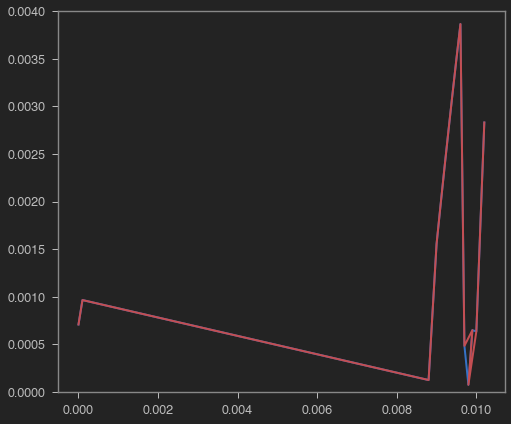

In [161]:
#better method: take more data!
# df, dict_greater_dict, dict_lesser_dict=separate_data_to_pandas(pdict)
# # df=pd.DataFrame(dict_particle_out)
d1=df[(df.pid==0.)&(df.x<2000)]
d2=df[(df.pid==1.)&(df.x<2000)]
# d=df[(df.pid==0.)]
x1_values=d1.t.values[-1]-d1.t.values
x2_values=d2.t.values[-1]-d2.t.values

# y_values=d.x.values#[1:-1]
# y_values=d.lesser_arclen.values#[1:-1]
y_values=d.lesser_arclen.values#[1:-1]
c_values=d.t.values#[1:-1]
plt.plot(x1_values,d1.lesser_arclen.values,lw=2)#,label='arclength of activation front')#,c=c_values)
plt.plot(x1_values,d1.greater_arclen.values,lw=2)#,label='arclength of activation front')#,c=c_values)
plt.plot(x2_values,d2.lesser_arclen.values,lw=2)
plt.plot(x2_values,d2.greater_arclen.values,lw=2)
# plt.plot(x_values,sigma_max_values_values,lw=2,label='arclength of activation front')
# plt.xlim([0,0.1])
plt.ylim([0,0.004])
# plt.yscale('log')
# plt.xscale('log')
plt.show()

In [ ]:
#TODO(later? to verify data that I can just retake more carefully...): show that each particle has one position per time
d=df[(df.pid==0.)]#&(df.x<2000)]


In [148]:
#TODO(later? to reconstruct max_sigma versus time...): show that each particle has one position per time
d=df[(df.pid==0.)]#&(df.x<2000)]
xyt_values1=np.array(list(zip(d.x.values,d.y.values,d.t.values)))
d=df[(df.pid==1.)]#&(df.x<2000)]
xyt_values2=np.array(list(zip(d.x.values,d.y.values,d.t.values)))
Dxyt_values=xyt_values2-xyt_values1

#select values with equal times only
boo=Dxyt_values[:,-1]==0.
Dxy_values=Dxyt_values[boo][:,:1]
t_values=xyt_values1[boo][:,-1]

array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.0018,
        0.0018,  0.0018,  0.0003,  0.0003,  0.0003,  0.0003,  0.0003,
        0.0003,  0.0003,  0.0003,  0.0003,  0.0003,  0.0003, -0.0029,
       -0.0029, -0.0029,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0. 

In [155]:
# dt_values=np.around(np.diff(t_values),9)
dt_lst=[]
#TODO: handle edge cases by just iterating through each time step....
for i in range(1,t_values.shape[0]-1):
    t_cur=t_values[i]
    dt_prv=t_cur-t_values[i-1]
    t_nxt=t_values[i+1]
    
np.diff(dt_values)

array([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00, -9.9000e-03,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  3.2000e-03, -3.2000e-03,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.00

In [ ]:
#TODO: linearly track lesser_arclen of these two death events on a dt=0.001 ms timescale fixed. 
#TODO: test proposition that lesser_arclen always drops shortly annihilating, perhaps on the 0.01~0.02 (ms?) timescale.  
# ^This would support the mechanism of annihilation involving the connection of activation fronts/strings with some tension to contract
# ^This would support using a model of spiral tip dynamics along an activation front to inform our reaction rate calculations
# HINT: consider rate = 1/expected_time_to_death, where the arclength behaves in a predictable way, i.e.
# dsigma_max_dt=foo(sigma_max;relative phase?)

In [119]:
sigma_max_values1=np.array(pdict[0]['greater_arclen'])
np.array(pdict[1]['greater_arclen'])
sigma_max_values

array([14.16732614, 15.26884531, 15.31004769, 15.35159101, 15.39313552,
       15.43450346, 15.47579706, 15.51710086,  7.85755483,  0.08648543,
        0.08666914,  0.08685307,  0.08703722,  0.08722157,  0.08740614,
        0.08759091,  0.0877759 ,  0.04090867,  0.0409222 ,  0.04093615,
        0.04095054,  0.04096537,  0.04098065,  0.04099639,  0.04101259,
        0.04102927,  0.04104644,  0.0410641 ,  0.04108226,  0.04110093,
        0.04112011,  0.04113983,  0.04116008,  0.04118088,  0.04120223,
        0.04122415,  0.04124664,  0.04126971,  0.04129337,  0.04131763,
        0.04134249,  0.04136798,  0.04139409,  0.04142083,  0.04144822,
        0.04147626,  0.04150497,  0.04153434,  0.0415644 ,  0.04159514,
        0.04162658,  0.04165872,  0.04169159,  0.04172526,  0.04176248,
        0.04180048,  0.04183927,  0.04187886,  0.04191926,  0.04196047,
        0.04200252,  0.04204539,  0.04208912,  0.04213369,  0.04217913,
        0.04222544,  0.04227262,  0.0423207 ,  0.04236966,  0.04

In [ ]:
#(not tested) #TODO: cast pdict into df
# # def to_pandas(self):
# primitive = (int, str, bool)
# def is_primitive(thing):
#     return isinstance(thing, primitive)

#         ds=dict(self)
#         dself={}
#         #if values are a list of primitives,
#         for key in list(ds.keys()):
#             values=ds[key]
#             if (type(values) is type(list())):#&(is_primitive(values[0])):
#                 dself[key]=values
#         df=pd.DataFrame(dself)
#         df['pid']=self.pid
#         cols = df.columns.tolist()
#         cols = cols[-1:] + cols[:-1]
#         return df[cols]
# #TODO: aggregating small particles might be necessary...

In [ ]:
# #access to full particle1 data
# ds=dict(pdict[0])
# ds.keys()

In [110]:
df.head()

,x,y,t,lesser_pid,lesser_arclen,greater_pid,greater_arclen,s1,s2,pid,greater_mean_V,lesser_mean_V,greater_mean_curvature,lesser_mean_curvature
0,2241.016086,1343.752410,219.80,1,8.663331,3,15.268845,1.0,6.0,0.0,-84.013949,-83.998421,126.702620,3.671369
1,2241.013688,1343.627449,219.81,1,8.663285,3,15.310048,1.0,7.0,0.0,-84.016495,-84.001034,58.778823,3.659323
2,2241.011456,1343.498613,219.82,1,8.663196,3,15.351591,1.0,7.0,0.0,-84.016429,-84.001061,34.652304,3.648136
3,2241.009402,1343.366156,219.83,1,8.663072,3,15.393136,1.0,8.0,0.0,-84.016444,-84.001088,23.460462,3.637790
4,2241.007540,1343.230084,219.84,1,8.662916,3,15.434503,1.0,4.0,0.0,-84.016459,-84.001114,17.622397,3.628266


In [ ]:
#DONT: reconstruct the cartesian distance between particles versus time
#TODO: isolate x,y,t for particle 0,1 as xyt_values0,1
#TODO: compute distance in pixels versus time as dist_values (np.linalg.norm... these tips are in the bulk...)
#TODO: group by dt, where dt=edge_cases_foo(diff(t))
#TODO: for each group, DS is given by dict, dt_to_L.
#TODO: visualize the cartesian distance between particles versus time



In [ ]:
#TODO: visualize the lesser_arclen distance between particles versus time
p1=df[df.pid==0.]
p2=df[df.pid==1.]


In [125]:
# #DONE: confirmed the mean location is roughly the same 
# #compute minimum distance of all pid found
# item_lst=[]
# for i in range(n_tips):
#     for j in range(n_tips):
#         if i > j:
#             #the ith tip location
#             point1=xy_values[i]
#             #the jth tip location
#             point2=xy_values[j]
#             #their distance, in cm
#             dist=comp_distance(point1,point2)
#             #add to list of distances
#             item=(dist,i,j)
#             item_lst.append(item)
# item_lst=sorted(item_lst)
# item_lst

In [35]:
#TODO: recursively zoom into the first/given death up to atol.  return pdict upto that point
#TODO(later): repeat while there are still pid_pairs to zoom into


(200, 200, 18)


In [60]:
# #TODO: test measure_kernel
# retval=find_tips_with_pbc_knots_full_color(contours1, contours2, s1in_lst, s2in_lst, txt)
# s1_list, s2_list, x_lst, y_lst, txt_lst=retval
# #TODO: call ^this function with contours_to_simple_tips_pbc_full_color

In [94]:
# TODO: visualize deaths

True

In [126]:
txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=1000,V_threshold=V_threshold,pid_pair=pid_pair)
    t_death_lst.append(t_prev+dt)
    

[218.81, 238.8099999999818]

In [95]:
txt_in=load_buffer(txt_fn)

retval_lst=recursive_zoom_to_death(pid_pair_lst,txt_in,dt,V_threshold=-50.,atol=1e-2,
                            one_steps_per_frame=100,ds=5.)
t_death,min_sigma_max

TypeError: init_system() missing 3 required positional arguments: 'txt_in', 'ds', and 'dt'

In [137]:
# # def find_starting_point(pdict,pid_pair,**kwargs):
# #     #TODO: follow pdict back to the birth of this pid_pair.  Supposes pid_pair denotes a birth
# #     #TODO(don't): modify find_stopping point
# #     pass


# def zoom_in(txt,pdict,dt,level1,level2,tfactor=0.1,**kwargs):
#     '''
#     Example Usage:
#     txt_prev, pdict, comp_tips, one_step=zoom_in(txt_prev,pdict,dt,level1,level2,tfactor=0.1)
#     '''
#     # zooming in as needed, until a certain absolute tolerance is found in a zero minimum distance between tips is reached.  
#     dt=tfactor*dt
#     width,height=txt.shape[:2]
#     comp_tips=get_comp_dict_topo_full_color(width=width,height=height,level1=level1,level2=level2)
#     # get_one_step at this dt (Luo-Rudy model)
#     __, arr39, one_step = get_one_step_explicit_synchronous_splitting(
#         nb_dir,dt=dt,width=width,height=height,ds=ds,diffCoef=0.0005,Cm=1.0)
    
#     txt,pdict=zoom_system(txt,pdict)
#     return txt, pdict, dt, comp_tips, one_step

# def zoom_system(txt,pdict):
#     txt=zoomin_txt(txt)
#     pdict=pdict.zoom_to_double()
#     return txt,pdict

# # def zoom_system(system, dt, pdict):
# #     zoom_in(txt,pdict,dt,level1,level2,tfactor=0.1)
# #     for systm in system:
# #         t_prev,pid_pair,txt_prev=systm
# #         txt, pdict, comp_tips, one_step=zoom_in(txt,pdict,dt,level1=-50,level2=0.,tfactor=0.1)
# #         #TODO: zoom_system (HINT: ctrl+F for zoom_ in lib)
# #     system=txt, pdict, dt, comp_tips, one_step

# TODO: test/dev recursive_zoom_to_death
then,<br>
TODO: define recursive_zoom_to_birth

In [135]:
#TODO: use record_tips_return_txt in studying birth events 
duration=1
txt=pdict.record_tips_return_txt(txt,duration,one_step,comp_tips,dt,save_every_n_frames=1)#,**kwargs)

txt_prev, pdict, dt, comp_tips, one_step=zoom_in(txt_prev,pdict,dt,level1=V_threshold,level2=0.,tfactor=tfactor)

NameError: name 'duration' is not defined

In [138]:
txt_prev, pdict, dt, comp_tips, one_step=zoom_in(txt_prev,pdict,dt,level1=V_threshold,level2=0.,tfactor=tfactor)

# dev methods for measuring activation front motion
- TODO(later): calibrate pdict contour detection 

(200, 200, 18)


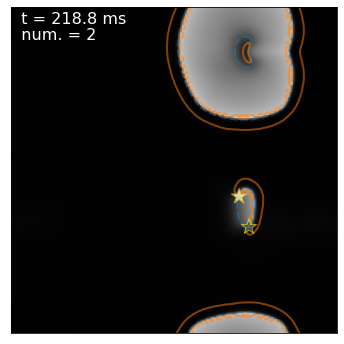

In [4]:
dt=0.001
txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_218.8.npz'
t=218.8;ds=5.;V_threshold=-50.
txt=load_buffer(txt_fn)
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
width,height=txt.shape[:2]
print(txt.shape)
one_step,comp_distance,comp_dict_tips=init_methods(width,height,ds,dt,V_threshold=V_threshold,jump_threshold=40)
comp_dict_topo_full_color=comp_dict_tips
#reidentify the tips to be tracked
img=inVc[...,0];dimgdt=dVcdt[...,0]
dict_tips=comp_dict_tips(img, dimgdt, t, txt)
pdict=ParticlePBCDict(dict_tips=dict_tips, width=width, height=width)#, **kwargs)
t_prev=t;txt_prev=txt.copy()

#visualize token death system
x_values=np.array(dict_tips['x'])[:-2]
y_values=np.array(dict_tips['y'])[:-2]
c_values=np.array(dict_tips['pid'])[:-2]
fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,inch=6,
                 fontsize=16,vmin_img=-85.,vmax_img=35.,area=25,
                 frameno=None,#frameno,
                 save_fn=None,#save_fn,
                 save_folder=None,#save_folder,
                 save=False,#True,
                 annotating=True,
                 axis=[0,img.shape[0],0,img.shape[1]])

#better method: take more data! (after condensing data to a simple readout)
#DONE/DONT(later): look for more reliable way to identify activation fronts... use consistency of position over time??
# HINT: consider looking at mean gating variables from the comp_dict_topo_full_color
#TODO: linearly record data for ^these spiral tips at a high sampling rate (and fine spatial resolution)

#TODO(brainwarmer): check Slides for whether tips move along dVdt levelsets or along V levelsets
#TODO: load/plot system
#TODO: compute each of the the final scalar values needed for the following...
#TODO: test angular difference between cartesion acceleration and acceleration in the direction of the activation front versus time
#TODO: linearly track lesser_arclen of these two death events on a dt=0.001 ms timescale fixed at the basic subpixel resolution
#TODO: test proposition that lesser_arclen always drops shortly annihilating, perhaps on the 0.01~0.02 (ms?) timescale.  
# ^This would support the mechanism of annihilation involving the connection of activation fronts/strings with some tension to contract
# ^This would support using a model of spiral tip dynamics along an activation front to inform our reaction rate calculations
# HINT: consider rate = 1/expected_time_to_death, where the arclength behaves in a predictable way, i.e.
# dsigma_max_dt=foo(sigma_max;relative phase?)

# from inspect import getsource
# print ( getsource(pdict.record_tips_return_txt))
# pdict.record_tips_return_txt?
ntips=len(dict_tips['x'])
assert(ntips>0)

inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
frameno=0
change_time=0.
duration =0.03
save_every_n_frames=1
while change_time<=duration:
# while ntips>0:
    frameno+=1
    t+=dt
    change_time+=dt
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    if frameno % save_every_n_frames == 0:
        dict_tips=comp_dict_tips(img, dimgdt, t, txt)
        pdict.merge_dict(dict_tips)
        ntips=len(dict_tips['x'])
        print(f"saved at time {t:.3f} ms.",end='\r')

txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)

In [58]:
#get all positions at two adjacent frames
pid_pair=(0,1)#(2,3)#UNCOMMENT
df, dict_greater_dict, dict_lesser_dict=pdict.separate_data_to_pandas()

In [59]:
# df.pid.values
pdict[1]

(size,t,x,y)=(31,218.830,146.100,65.229);

In [61]:
#extract the relevant particles
d1=df[df.pid==float(pid_pair[0])].copy()
d2=df[df.pid==float(pid_pair[1])].copy()

#compute velocities of particles
dsdpixel=ds/width
d1['vx']=d1.diff().shift(-1)[['x']]*dsdpixel/dt #cm/s
d1['vy']=d1.diff().shift(-1)[['y']]*dsdpixel/dt #cm/s
d2['vx']=d2.diff().shift(-1)[['x']]*dsdpixel/dt #cm/s
d2['vy']=d2.diff().shift(-1)[['y']]*dsdpixel/dt #cm/s

#compute speeds of particles
d1['speed']=np.sqrt(d1['vx']**2+d1['vy']**2)
d2['speed']=np.sqrt(d2['vx']**2+d2['vy']**2)

In [115]:
#compute the velocity unit vectors for either tip
v1_hat_values=np.array(list(zip(d1['vx']/d1['speed'],d1['vy']/d1['speed'])))
v2_hat_values=np.array(list(zip(d2['vx']/d2['speed'],d2['vy']/d2['speed'])))

#compute displacement unit vector from tip 1 to tip 2
xy1_values=np.array(list(zip(d1['x'],d1['y'])))
xy2_values=np.array(list(zip(d2['x'],d2['y'])))
xy2_minus_xy1_values=xy2_values-xy1_values
x2_minus_x1_hat_values=xy2_minus_xy1_values[:,0]/np.linalg.norm(xy2_minus_xy1_values,axis=1)
y2_minus_y1_hat_values=xy2_minus_xy1_values[:,1]/np.linalg.norm(xy2_minus_xy1_values,axis=1)
xy2_minus_xy1_hat_values=np.array(list(zip(x2_minus_x1_hat_values,y2_minus_y1_hat_values)))

#time values
t1_values=d1['t'].values

In [66]:
#compute directions of activation fronts.  store as pandas.DataFrame.
dict_activation_front=dict_lesser_dict[pid_pair[0]]
daf=dict_activation_front
daf.keys()

t_values=np.array(daf['t'])[1:]

xy_values_lst=daf['lesser_xy_values']
len(xy_values_lst)

dict_keys(['lesser_V_values', 'lesser_arclen_values', 'lesser_curvature_values', 'lesser_xy_values', 'lesser_pid', 'pid', 't'])

In [106]:
#DONE: confirmed coordinates are lined up
# xy_values[:3][0][0]-float(d1[d1.t==t_values[i]].x.values)
#DONE: confirmed the ith particle value corresponds to the ith contour value

In [142]:
dx1dx2_hat=xy2_minus_xy1_hat_values[i]
# print(t1_values[i])

#TODO(if naive is ugly...): try moving avg of first j contour points for the ith observation time
i=7
xy_values=xy_values_lst[i]

#TODO: compute a1_hat and a2_hat
a1=xy_values[1]-xy_values[0]
# xy_values[2]-xy_values[1]
# xy_values[3]-xy_values[2]
# xy_values[4]-xy_values[3]
a1_hat=a1/np.linalg.norm(a1)

a2=xy_values[-2]-xy_values[-1]
a2_hat=a2/np.linalg.norm(a2)

#TODO(later, to scale method): convert all subtraction operations to explicitely enforce pbc...
# print(t_values[i])

#assert we're comparing the right times
assert ( t_values[i] == t1_values[i])

phi1=np.arcsin(np.cross(dx1dx2_hat,a1))
phi2=np.arcsin(np.cross(-dx1dx2_hat,a2))
phi_sum=phi2+phi1
phi_diff=phi2-phi1
# return phi_sum, phi_diff

print(f"phi1,phi2={phi1:.3f},{phi2:.3f} at time {t_values[i]:.3f}.")
print(f"phi_sum,phi_diff={phi_sum:.3f},{phi_diff:.3f} at time {t_values[i]:.3f}.")

phi1,phi2=-0.136,0.102 at time 218.808.
phi_sum,phi_diff=-0.034,0.238 at time 218.808.


In [117]:
t0=218.83000000000015

In [120]:
tf=249.8#256.2

# inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
# frameno=0
# change_time=0.
# duration =0.03
save_every_n_frames=1
# while change_time<=duration:
# while ntips>0:
while t<tf:
    frameno+=1
    t+=dt
#     change_time+=dt
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
#     if frameno % save_every_n_frames == 0:
#         dict_tips=comp_dict_tips(img, dimgdt, t, txt)
#         pdict.merge_dict(dict_tips)
#         ntips=len(dict_tips['x'])
#         print(f"saved at time {t:.3f} ms.",end='\r')
    print(f"txt is at time {t:.3f} ms.",end='\r')

txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)

In [123]:
beep(5)
#visualize token death system just before they annihilate
img=inVc[...,0];dimgdt=dVcdt[...,0]
dict_tips=comp_dict_tips(img, dimgdt, t, txt)
# pdict=ParticlePBCDict(dict_tips=dict_tips, width=width, height=width)#, **kwargs)
# t_prev=t;txt_prev=txt.copy()

#visualize token death system
x_values=np.array(dict_tips['x'])[:-2]
y_values=np.array(dict_tips['y'])[:-2]
c_values=np.array(dict_tips['pid'])[:-2]
fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,inch=6,
                 fontsize=16,vmin_img=-85.,vmax_img=35.,area=25,
                 frameno=None,#frameno,
                 save_fn=None,#save_fn,
                 save_folder=None,#save_folder,
                 save=False,#True,
                 annotating=True,
                 axis=[0,img.shape[0],0,img.shape[1]])

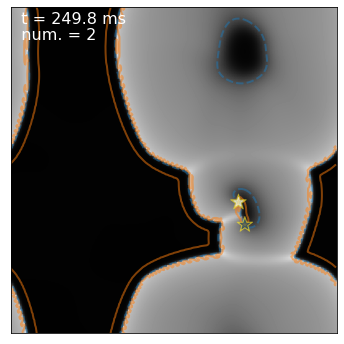

In [124]:
img=inVc[...,0].T;dimgdt=dVcdt[...,0].T
dict_tips2=comp_dict_tips(img, dimgdt, t, txt)
#visualize token death system
x_values=np.array(dict_tips2['x'])#[:-2]
y_values=np.array(dict_tips2['y'])#[:-2]
c_values=np.array(dict_tips2['pid'])#[:-2]
fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,inch=6,
                 fontsize=16,vmin_img=-85.,vmax_img=35.,area=25,
                 frameno=None,#frameno,
                 save_fn=None,#save_fn,
                 save_folder=None,#save_folder,
                 save=False,#True,
                 annotating=True,
                 axis=[0,img.shape[0],0,img.shape[1]])

In [159]:
#compute the pdict2 at the current/next frame
pdict2=ParticlePBCDict(dict_tips=dict_tips2, width=width, height=width)#, **kwargs)
pdict2.merge_dict(dict_tips2)
# pdict2[0].keys()
df2, dict_greater_dict2, dict_lesser_dict2=pdict2.separate_data_to_pandas()
#extract the relevant particles
d1=df2[df2.pid==float(pid_pair[0])].copy()
d2=df2[df2.pid==float(pid_pair[1])].copy()

In [160]:
#compute displacement unit vector from tip 1 to tip 2
xy1_values=np.array(list(zip(d1['x'],d1['y'])))
xy2_values=np.array(list(zip(d2['x'],d2['y'])))
xy2_minus_xy1_values=xy2_values-xy1_values
x2_minus_x1_hat_values=xy2_minus_xy1_values[:,0]/np.linalg.norm(xy2_minus_xy1_values,axis=1)
y2_minus_y1_hat_values=xy2_minus_xy1_values[:,1]/np.linalg.norm(xy2_minus_xy1_values,axis=1)
xy2_minus_xy1_hat_values=np.array(list(zip(x2_minus_x1_hat_values,y2_minus_y1_hat_values)))

#time values
t1_values=d1['t'].values

In [163]:
#compute directions of activation fronts.  store as pandas.DataFrame.
dict_activation_front=dict_lesser_dict2[pid_pair[0]]
daf=dict_activation_front
daf.keys()

t_values=np.array(daf['t'])#[1:]

xy_values_lst=daf['lesser_xy_values']
len(xy_values_lst)

1

In [164]:
i=0
dx1dx2_hat=xy2_minus_xy1_hat_values[i]
# print(t1_values[i])

#TODO(if naive is ugly...): try moving avg of first j contour points for the ith observation time

xy_values=xy_values_lst[i]

#TODO: compute a1_hat and a2_hat
a1=xy_values[1]-xy_values[0]
# xy_values[2]-xy_values[1]
# xy_values[3]-xy_values[2]
# xy_values[4]-xy_values[3]
a1_hat=a1/np.linalg.norm(a1)

a2=xy_values[-2]-xy_values[-1]
a2_hat=a2/np.linalg.norm(a2)

#TODO(later, to scale method): convert all subtraction operations to explicitely enforce pbc...
# print(t_values[i])

#assert we're comparing the right times
print (( t_values[i] , t1_values[i]))
assert ( t_values[i] == t1_values[i])

phi1=np.arcsin(np.cross(dx1dx2_hat,a1))
phi2=np.arcsin(np.cross(-dx1dx2_hat,a2))
phi_sum=phi2+phi1
phi_diff=phi2-phi1
# return phi_sum, phi_diff

print(f"phi1,phi2={phi1:.3f},{phi2:.3f} at time {t_values[i]:.3f}.")
print(f"phi_sum,phi_diff={phi_sum:.3f},{phi_diff:.3f} at time {t_values[i]:.3f}.")

(249.80000000014803, 249.80000000014803)
phi1,phi2=-0.093,-0.140 at time 249.800.
phi_sum,phi_diff=-0.233,-0.047 at time 249.800.


$$
\text{Let   } \varphi_1\equiv\sin^{-1}\big(\widehat{\mathbf{x}_2-\mathbf{x}_1}\;\times\;\hat{\mathbf{a}}_1\big),
$$

$$
\text{and let   } \varphi_2\equiv\sin^{-1}\big(\widehat{\mathbf{x}_1-\mathbf{x}_2}\;\times\;\hat{\mathbf{a}}_2\big).
$$